In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
from sklearn.model_selection import KFold
import torch.nn.functional as F
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt
import seaborn as sns
import time
from PIL import ImageFilter
import random

In [21]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

# Random Gaussian Blur
class RandomGaussianBlur(object):
    def __init__(self, radius_min=0.5, radius_max=1.5, p=0.5):
        self.radius_min = radius_min
        self.radius_max = radius_max
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            radius = random.uniform(self.radius_min, self.radius_max)
            return img.filter(ImageFilter.GaussianBlur(radius=radius))
        return img


In [22]:
# Check if CUDA is available and use GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [23]:
transform = transforms.Compose([
    transforms.RandomApply([
        RandomGaussianBlur(radius_min=0.5, radius_max=1.5, p=1.0)
    ], p=0.5),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.1),
    transforms.Normalize((0.1307,), (0.3081,))
])


In [24]:
train_dataset = datasets.MNIST(root='./data1', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data1', train=False, download=True, transform=transform)


In [25]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # First convolutional layer
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization after first convolution
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Second convolutional layer
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization after second convolution
        self.fc1_input_size = 64 * 7 * 7  # Input size for the first fully connected layer (adjust as needed)
        self.fc1 = nn.Linear(self.fc1_input_size, 128)  # First fully connected layer
        self.fc2 = nn.Linear(128, 10)  # Output layer (10 classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Apply batch normalization after the first convolution
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # First pooling layer

        x = self.conv2(x)
        x = self.bn2(x)  # Apply batch normalization after the second convolution
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # Second pooling layer

        x = torch.flatten(x, 1)  # Flatten the output for fully connected layers
        x = F.relu(self.fc1(x))  # First fully connected layer with ReLU activation
        x = self.fc2(x)  # Output layer
        return x

In [26]:
# Parameters
batch_size = 64
num_epochs = 5
learning_rate = 0.001
k = 5  # K-Fold
prune_amount = 0.2

In [27]:
def train_model(model, train_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    return running_loss / len(train_loader)

In [28]:
def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)
    return correct / total

In [29]:
# K-Fold Cross Validation and Comparison of Pruning Methods
kfold = KFold(n_splits=k, shuffle=True)
non_pruned_accuracies = []
non_pruned_times = []  # Add this line to track training times for non-pruned model
pruned_accuracies = {
    "Magnitude-Based": [],
    "Structured": [],
    "Random": [],
    "Gradient-Based": [],
    "filter":[],
    "channel":[]
}
pruned_times = {
    "Magnitude-Based": [],
    "Structured": [],
    "Random": [],
    "Gradient-Based": [],
    "filter":[],
    "channel":[]
}

In [31]:
for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(train_dataset)))):
    print(f'Fold {fold + 1}/{k}')
    # Create samplers and dataloaders for training and validation sets
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

    # Initialize the model
    model = CNNModel().to(device)

    # Train the model without pruning
    print("Training Non-Pruned Model...")
    start_time = time.time()
    train_model(model, train_loader)
    non_pruned_accuracy = evaluate_model(model, val_loader)
    non_pruned_accuracies.append(non_pruned_accuracy)
    non_pruned_time = time.time() - start_time
    non_pruned_times.append(non_pruned_time)  # Track the time taken for the non-pruned model
    print(f'Non-Pruned Accuracy: {non_pruned_accuracy:.4f}, Time: {non_pruned_time:.2f}s')

Fold 1/5
Training Non-Pruned Model...
Non-Pruned Accuracy: 0.9850, Time: 108.15s
Fold 2/5
Training Non-Pruned Model...
Non-Pruned Accuracy: 0.9820, Time: 107.03s
Fold 3/5
Training Non-Pruned Model...
Non-Pruned Accuracy: 0.9818, Time: 105.52s
Fold 4/5
Training Non-Pruned Model...
Non-Pruned Accuracy: 0.9823, Time: 105.60s
Fold 5/5
Training Non-Pruned Model...
Non-Pruned Accuracy: 0.9818, Time: 109.41s


In [32]:
 # **1. Magnitude-Based Pruning (Unstructured)**
model_pruned = CNNModel().to(device)
prune.random_unstructured(model_pruned.conv1, name='weight', amount=prune_amount)  # Pruning Conv1
prune.random_unstructured(model_pruned.conv2, name='weight', amount=prune_amount)  # Pruning Conv2
print("Training Model after Magnitude-Based Unstructured Pruning...")
start_time = time.time()
train_model(model_pruned, train_loader)
accuracy = evaluate_model(model_pruned, val_loader)
pruned_accuracies["Magnitude-Based"].append(accuracy)
pruned_times["Magnitude-Based"].append(time.time() - start_time)
print(f'Unstructured Pruned Accuracy: {accuracy:.4f}, Time: {pruned_times["Magnitude-Based"][-1]:.2f}s')

Training Model after Magnitude-Based Unstructured Pruning...
Unstructured Pruned Accuracy: 0.9852, Time: 109.11s


In [33]:
 # **2. Structured Pruning**
model_structured = CNNModel().to(device)
prune.ln_structured(model_structured.conv1, name='weight', amount=prune_amount, n=2, dim=0)  # Structured Pruning Conv1
prune.ln_structured(model_structured.conv2, name='weight', amount=prune_amount, n=2, dim=0)  # Structured Pruning Conv2
print("Training Model after Structured Pruning...")
start_time = time.time()
train_model(model_structured, train_loader)
accuracy = evaluate_model(model_structured, val_loader)
pruned_accuracies["Structured"].append(accuracy)
pruned_times["Structured"].append(time.time() - start_time)
print(f'Structured Pruned Accuracy: {accuracy:.4f}, Time: {pruned_times["Structured"][-1]:.2f}s')

Training Model after Structured Pruning...
Structured Pruned Accuracy: 0.9858, Time: 109.60s


In [34]:
 # **3. Random Pruning**
model_random = CNNModel().to(device)
prune.random_unstructured(model_random.conv1, name='weight', amount=prune_amount)  # Randomly Pruning Conv1
prune.random_unstructured(model_random.conv2, name='weight', amount=prune_amount)  # Randomly Pruning Conv2
print("Training Model after Random Pruning...")
start_time = time.time()
train_model(model_random, train_loader)
accuracy = evaluate_model(model_random, val_loader)
pruned_accuracies["Random"].append(accuracy)
pruned_times["Random"].append(time.time() - start_time)
print(f'Random Pruned Accuracy: {accuracy:.4f}, Time: {pruned_times["Random"][-1]:.2f}s')


Training Model after Random Pruning...
Random Pruned Accuracy: 0.9826, Time: 107.09s


In [35]:
  # **4. Gradient-Based Pruning**
model_gradient = CNNModel().to(device)
optimizer = optim.Adam(model_gradient.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    model_gradient.train()
    running_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model_gradient(data)
        loss = F.cross_entropy(output, target)
        loss.backward()

        # Simple gradient-based pruning: zero out weights with small gradients
        for name, param in model_gradient.named_parameters():
            if 'weight' in name:
                with torch.no_grad():
                    param[torch.abs(param.grad) < 0.01] = 0  # Example threshold

        optimizer.step()
        running_loss += loss.item()

print("Evaluating Model after Gradient-Based Pruning...")
start_time = time.time()
accuracy = evaluate_model(model_gradient, val_loader)
pruned_accuracies["Gradient-Based"].append(accuracy)
pruned_times["Gradient-Based"].append(time.time() - start_time)
print(f'Gradient-Based Pruned Accuracy: {accuracy:.4f}, Time: {pruned_times["Gradient-Based"][-1]:.2f}s')

Evaluating Model after Gradient-Based Pruning...
Gradient-Based Pruned Accuracy: 0.1075, Time: 2.01s


In [36]:
# Filter Pruning (L1-Norm based)
model_filter = CNNModel().to(device)

# Prune conv1 filters
weight = model_filter.conv1.weight.data.abs().sum(dim=(1,2,3))
num_filters_to_prune = int(prune_amount * weight.size(0))
prune_indices = weight.topk(num_filters_to_prune, largest=False).indices
mask = torch.ones_like(model_filter.conv1.weight)
mask[prune_indices, :, :, :] = 0
model_filter.conv1.weight.data.mul_(mask)

# Prune conv2 filters
weight = model_filter.conv2.weight.data.abs().sum(dim=(1,2,3))
num_filters_to_prune = int(prune_amount * weight.size(0))
prune_indices = weight.topk(num_filters_to_prune, largest=False).indices
mask = torch.ones_like(model_filter.conv2.weight)
mask[prune_indices, :, :, :] = 0
model_filter.conv2.weight.data.mul_(mask)

print("Training Model after Filter Pruning...")
start_time = time.time()
train_model(model_filter, train_loader)
accuracy = evaluate_model(model_filter, val_loader)

# Initialize keys and append
if "Filter" not in pruned_accuracies:
    pruned_accuracies["Filter"] = []
if "Filter" not in pruned_times:
    pruned_times["Filter"] = []

pruned_accuracies["Filter"].append(accuracy)
pruned_times["Filter"].append(time.time() - start_time)
print(f'Filter Pruned Accuracy: {accuracy:.4f}, Time: {pruned_times["Filter"][-1]:.2f}s')


Training Model after Filter Pruning...
Filter Pruned Accuracy: 0.9792, Time: 107.52s


In [37]:
# Channel Pruning (L1-Norm based)
model_channel = CNNModel().to(device)

# Prune conv1 channels (input channels)
weight = model_channel.conv1.weight.data.abs().sum(dim=(0,2,3))
num_channels_to_prune = int(prune_amount * weight.size(0))
prune_indices = weight.topk(num_channels_to_prune, largest=False).indices
mask = torch.ones_like(model_channel.conv1.weight)
mask[:, prune_indices, :, :] = 0
model_channel.conv1.weight.data.mul_(mask)

# Prune conv2 channels (input channels)
weight = model_channel.conv2.weight.data.abs().sum(dim=(0,2,3))
num_channels_to_prune = int(prune_amount * weight.size(0))
prune_indices = weight.topk(num_channels_to_prune, largest=False).indices
mask = torch.ones_like(model_channel.conv2.weight)
mask[:, prune_indices, :, :] = 0
model_channel.conv2.weight.data.mul_(mask)

print("Training Model after Channel Pruning...")
start_time = time.time()
train_model(model_channel, train_loader)
accuracy = evaluate_model(model_channel, val_loader)

# Initialize dictionary keys before appending
if "Channel" not in pruned_accuracies:
    pruned_accuracies["Channel"] = []
if "Channel" not in pruned_times:
    pruned_times["Channel"] = []

pruned_accuracies["Channel"].append(accuracy)
pruned_times["Channel"].append(time.time() - start_time)
print(f'Channel Pruned Accuracy: {accuracy:.4f}, Time: {pruned_times["Channel"][-1]:.2f}s')


Training Model after Channel Pruning...
Channel Pruned Accuracy: 0.9822, Time: 106.07s


In [38]:
import pandas as pd
import numpy as np

# Create a DataFrame with the comparison data including Filter and Channel pruning
comparison_data = {
    "Pruning Method": [
        "Magnitude-Based",
        "Structured",
        "Random Pruning",
        "Gradient-Based",
        "Filter Pruning",
        "Channel Pruning",
        "Non-Pruned"
    ],
    "Accuracy": [
        np.mean(pruned_accuracies["Magnitude-Based"]),
        np.mean(pruned_accuracies["Structured"]),
        np.mean(pruned_accuracies["Random"]),
        np.mean(pruned_accuracies["Gradient-Based"]),
        np.mean(pruned_accuracies["Filter"]),
        np.mean(pruned_accuracies["Channel"]),
        np.mean(non_pruned_accuracies)
    ],
    "Training Time (s)": [
        np.mean(pruned_times["Magnitude-Based"]),
        np.mean(pruned_times["Structured"]),
        np.mean(pruned_times["Random"]),
        np.mean(pruned_times["Gradient-Based"]),
        np.mean(pruned_times["Filter"]),
        np.mean(pruned_times["Channel"]),
        np.mean(non_pruned_times)
    ],
}

# Create the DataFrame
df_comparison = pd.DataFrame(comparison_data)

# Display the comparison DataFrame
print("Comparison of Pruning Methods:")
print(df_comparison)


Comparison of Pruning Methods:
    Pruning Method  Accuracy  Training Time (s)
0  Magnitude-Based  0.985167         109.109183
1       Structured  0.985750         109.603975
2   Random Pruning  0.982583         107.091859
3   Gradient-Based  0.107500           2.008378
4   Filter Pruning  0.979250         107.521173
5  Channel Pruning  0.982167         106.073031
6       Non-Pruned  0.982667         107.545254


<Figure size 1200x600 with 0 Axes>

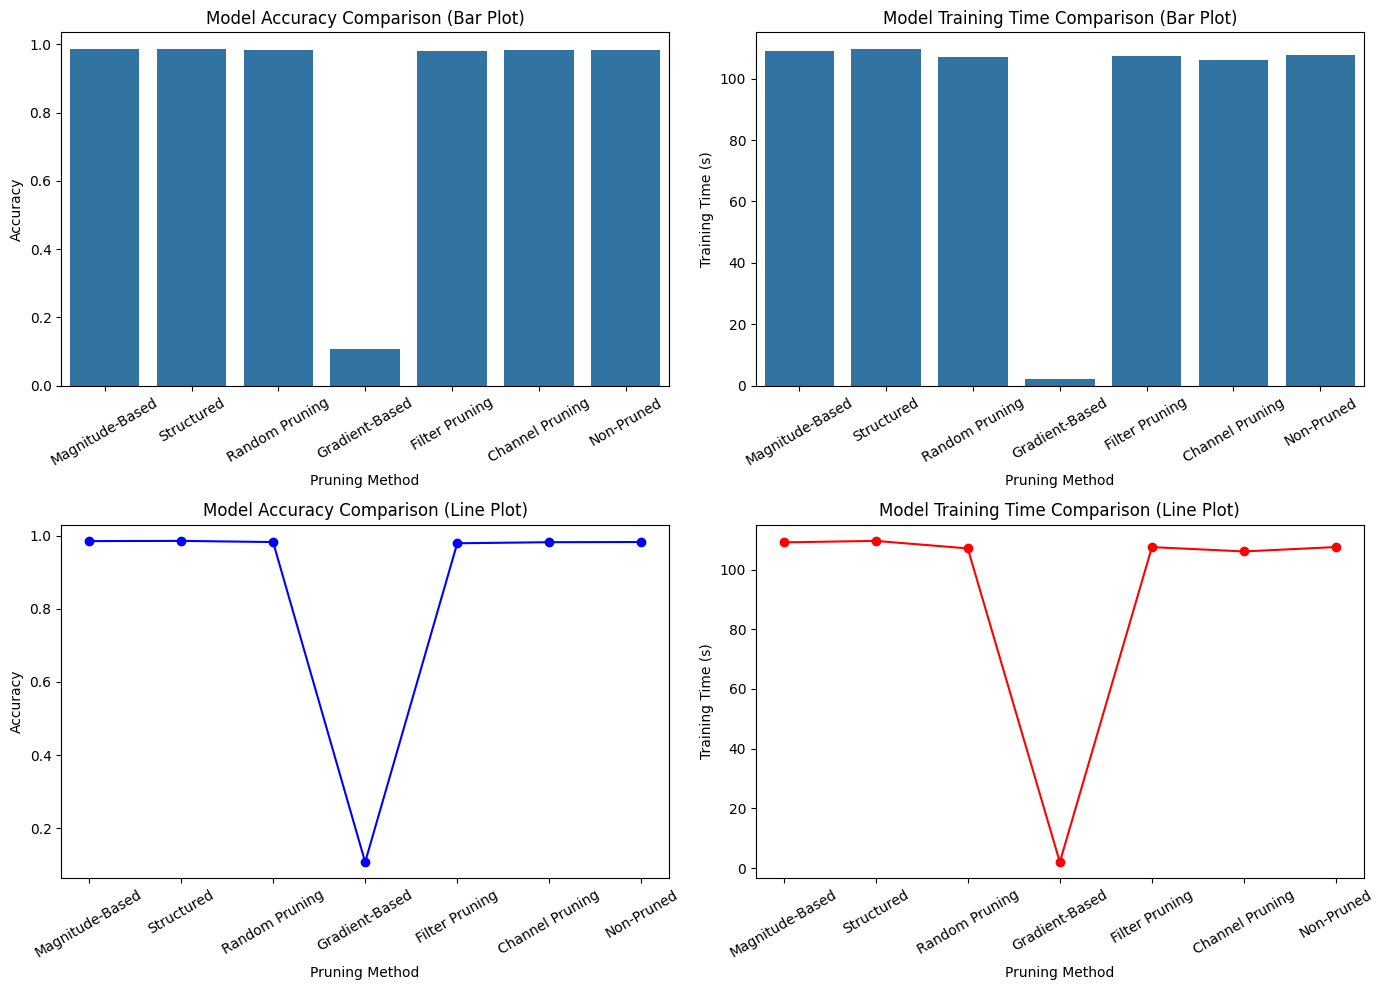

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a DataFrame with the comparison data including Filter and Channel pruning
comparison_data = {
    "Pruning Method": [
        "Magnitude-Based",
        "Structured",
        "Random Pruning",
        "Gradient-Based",
        "Filter Pruning",
        "Channel Pruning",
        "Non-Pruned"
    ],
    "Accuracy": [
        np.mean(pruned_accuracies["Magnitude-Based"]),
        np.mean(pruned_accuracies["Structured"]),
        np.mean(pruned_accuracies["Random"]),
        np.mean(pruned_accuracies["Gradient-Based"]),
        np.mean(pruned_accuracies["Filter"]),
        np.mean(pruned_accuracies["Channel"]),
        np.mean(non_pruned_accuracies)
    ],
    "Training Time (s)": [
        np.mean(pruned_times["Magnitude-Based"]),
        np.mean(pruned_times["Structured"]),
        np.mean(pruned_times["Random"]),
        np.mean(pruned_times["Gradient-Based"]),
        np.mean(pruned_times["Filter"]),
        np.mean(pruned_times["Channel"]),
        np.mean(non_pruned_times)
    ],
}

# Create the DataFrame
df_comparison = pd.DataFrame(comparison_data)

# Set the figure size for the plots
plt.figure(figsize=(12, 6))

# Create a subplot with 2 rows and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Bar plot for Accuracy
sns.barplot(x="Pruning Method", y="Accuracy", data=df_comparison, ax=axes[0, 0])
axes[0, 0].set_title('Model Accuracy Comparison (Bar Plot)')
axes[0, 0].set_xlabel('Pruning Method')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=30)

# Bar plot for Training Time
sns.barplot(x="Pruning Method", y="Training Time (s)", data=df_comparison, ax=axes[0, 1])
axes[0, 1].set_title('Model Training Time Comparison (Bar Plot)')
axes[0, 1].set_xlabel('Pruning Method')
axes[0, 1].set_ylabel('Training Time (s)')
axes[0, 1].tick_params(axis='x', rotation=30)

# Line plot for Accuracy
axes[1, 0].plot(df_comparison["Pruning Method"], df_comparison["Accuracy"], marker='o', linestyle='-', color='b')
axes[1, 0].set_title('Model Accuracy Comparison (Line Plot)')
axes[1, 0].set_xlabel('Pruning Method')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].tick_params(axis='x', rotation=30)

# Line plot for Training Time
axes[1, 1].plot(df_comparison["Pruning Method"], df_comparison["Training Time (s)"], marker='o', linestyle='-', color='r')
axes[1, 1].set_title('Model Training Time Comparison (Line Plot)')
axes[1, 1].set_xlabel('Pruning Method')
axes[1, 1].set_ylabel('Training Time (s)')
axes[1, 1].tick_params(axis='x', rotation=30)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
